In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'bank-additional-full.csv'
df = pd.read_csv(file_path, sep=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

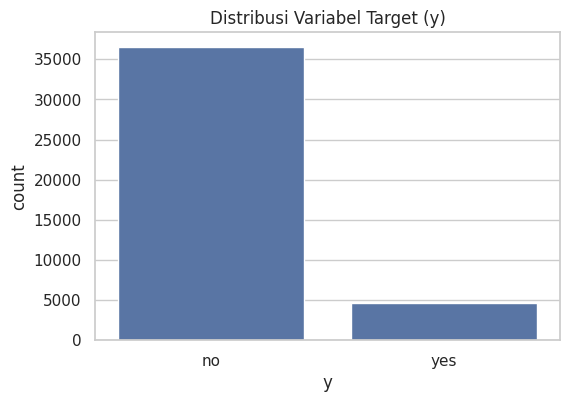

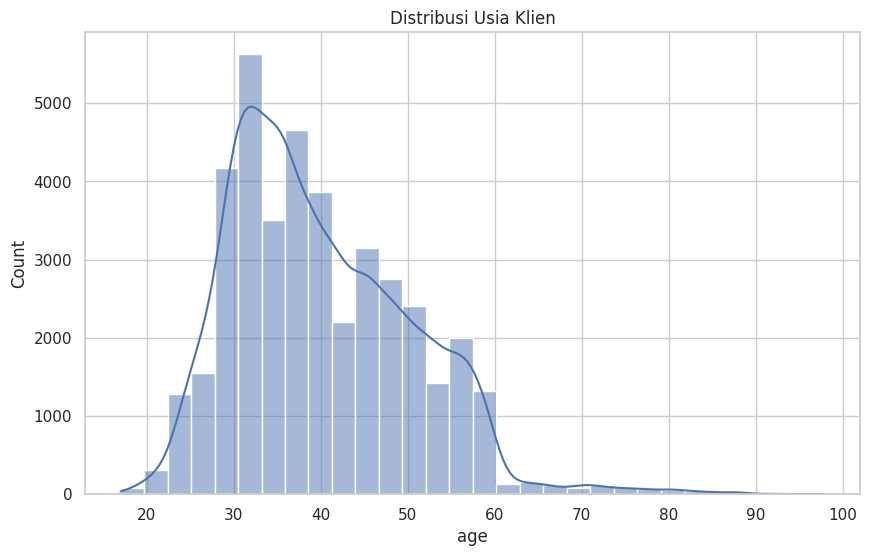

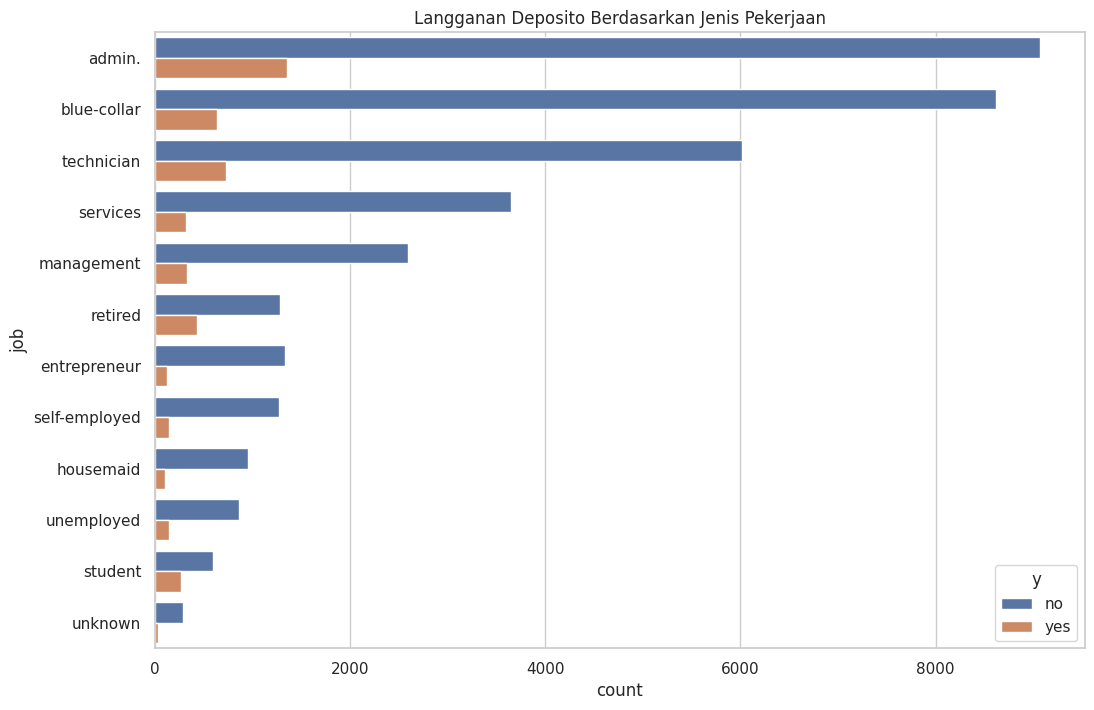

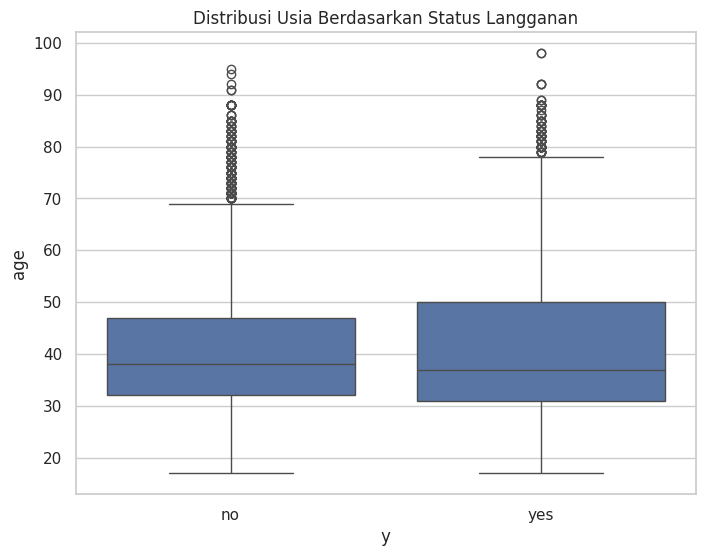

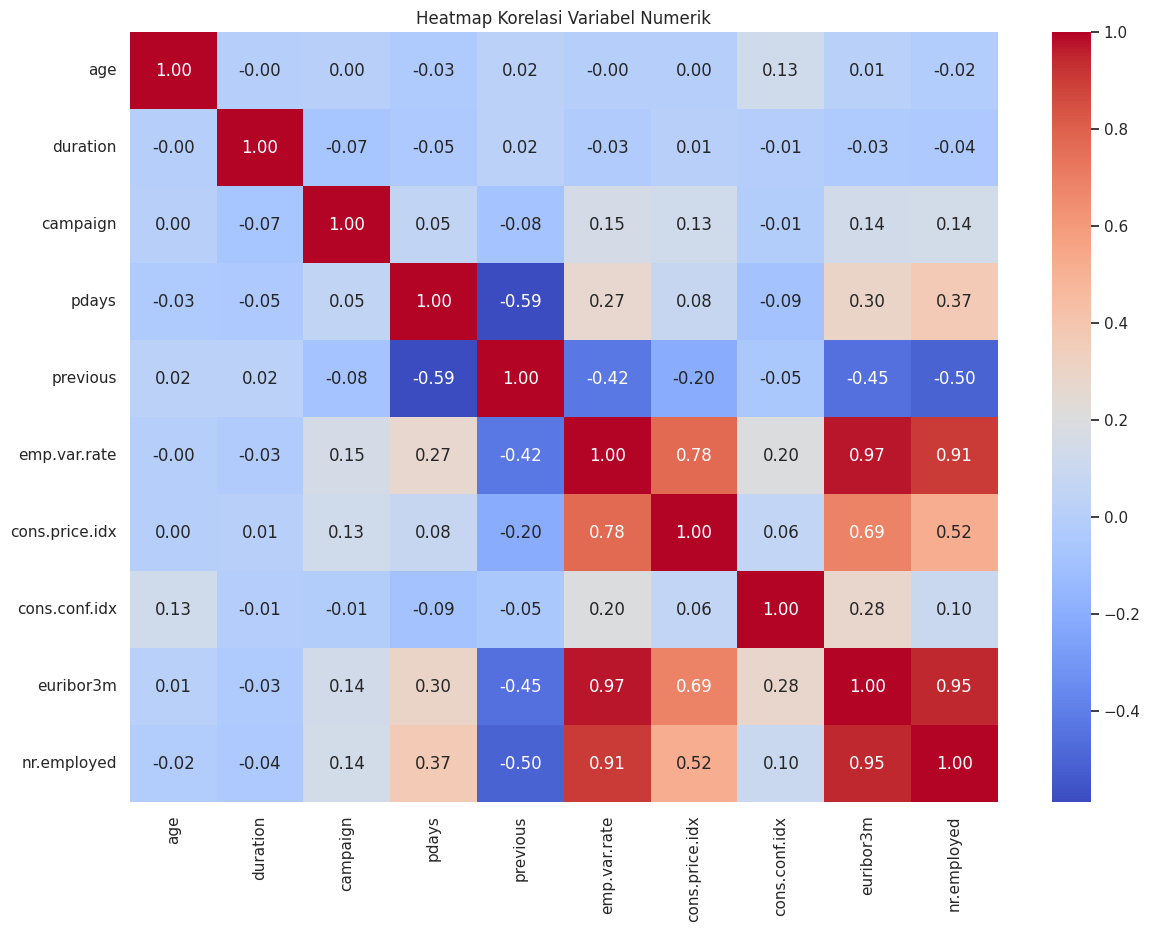

In [3]:
df.head()
df.info()
df.describe()

# Visualisasi
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title('Distribusi Variabel Target (y)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribusi Usia Klien')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='job', hue='y', data=df, order=df['job'].value_counts().index)
plt.title('Langganan Deposito Berdasarkan Jenis Pekerjaan')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='age', data=df)
plt.title('Distribusi Usia Berdasarkan Status Langganan')
plt.show()

plt.figure(figsize=(14, 10))
correlation_matrix = df.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Variabel Numerik')
plt.show()


In [4]:
df_processed = df.copy()
df_processed.drop_duplicates(inplace=True)

# Imputasi "unknown"
for col in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
    mode_value = df_processed[col].mode()[0]
    df_processed[col].replace('unknown', mode_value, inplace=True)

# Hapus kolom 'duration'
df_processed.drop('duration', axis=1, inplace=True)

# Encode target dan fitur kategorikal
df_processed['y'] = df_processed['y'].map({'no': 0, 'yes': 1})
categorical_cols = df_processed.select_dtypes(include=['object']).columns
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)


/tmp/ipython-input-4-300789176.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].replace('unknown', mode_value, inplace=True)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_processed.drop('y', axis=1)
y = df_processed['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

numerical_cols_to_scale = X_train.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale])


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Sebelum SMOTE:")
print(y_train.value_counts())
print("\nSetelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Sebelum SMOTE:
y
0    29229
1     3711
Name: count, dtype: int64

Setelah SMOTE:
y
0    29229
1    29229
Name: count, dtype: int64


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:52:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# Prediksi
y_pred_lr = log_reg.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

# Laporan
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

print("\nRandom Forest:\n", classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))

print("\nXGBoost:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      7308
           1       0.30      0.56      0.39       928

    accuracy                           0.80      8236
   macro avg       0.62      0.70      0.64      8236
weighted avg       0.87      0.80      0.83      8236

ROC AUC: 0.7526069682728422

Random Forest:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93      7308
           1       0.46      0.40      0.43       928

    accuracy                           0.88      8236
   macro avg       0.69      0.67      0.68      8236
weighted avg       0.87      0.88      0.88      8236

ROC AUC: 0.7771425504407075

XGBoost:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      7308
           1       0.53      0.37      0.43       928

    accuracy                           0.89      8236
   macro avg       0.7

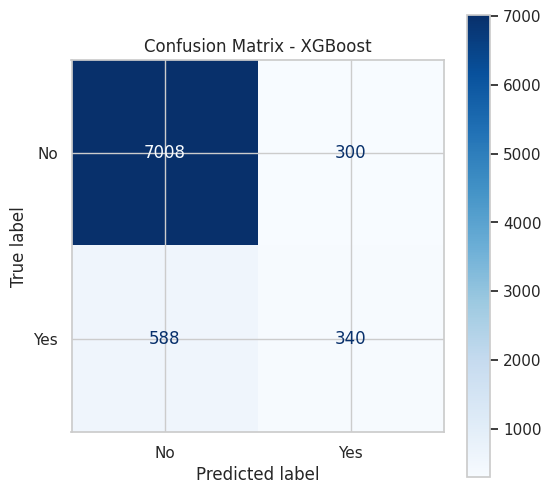

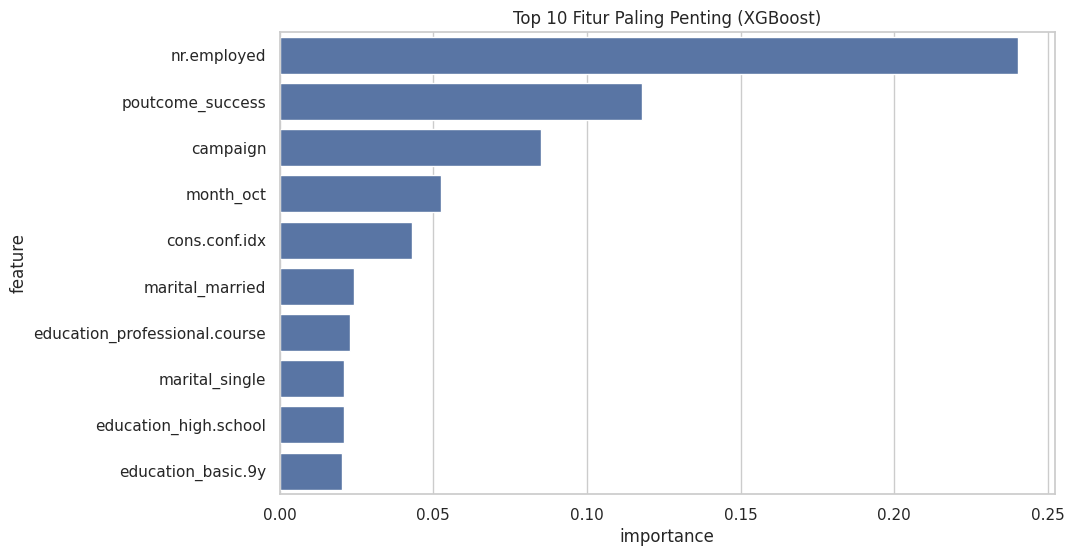

In [10]:
# Matrix untuk XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Feature Importance
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_clf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Top 10 Fitur Paling Penting (XGBoost)')
plt.show()
